/tmp/ipykernel_445073/853397980.py:33: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')


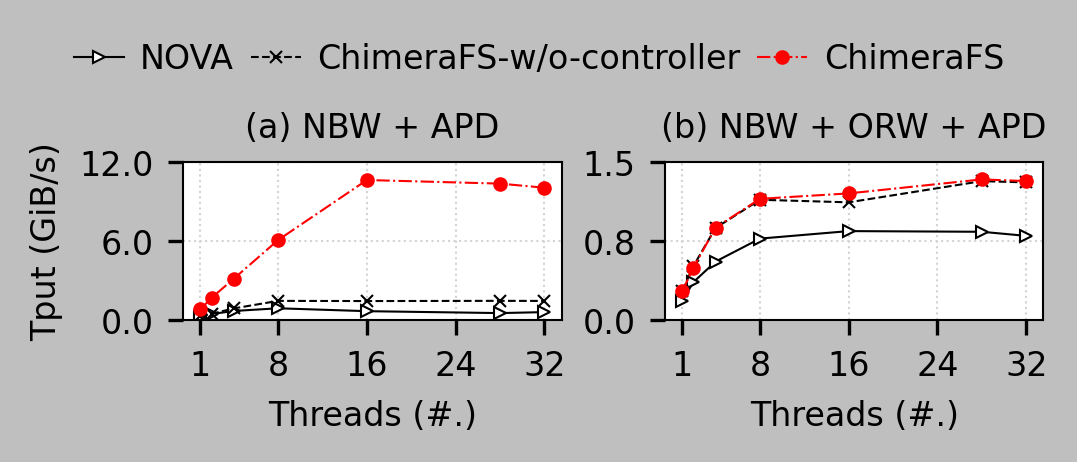

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54

# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

with open("./performance-comparison-table", "r") as f:
    df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(3)))

line_width = 0.5
# marks = [">", "x", "s", "D", "o", "o"]
marks = [">", "x", "o"]
line_patterns = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--", "-.", ":"]
fss = ["nova", "parfs-no-opt-append-12", "parfs-12"]
# num_jobs = range(1, 17)  
num_jobs = [1, 2, 4, 8, 16, 28, 32]
x = list(num_jobs) 
ops = ["write", "randwrite"]
df['bandwidth'] = df['bandwidth(MiB/s)'] / 1024
titles = ["(a) NBW + APD", "(b) NBW + ORW + APD"]
lines = []


df_avg = (
    df.groupby(['fs', 'ops', 'numjobs'])['bandwidth']
      .mean()
      .reset_index()
)

mapping = {
    "nova": "NOVA",
    "parfs-12":"ChimeraFS",
    "parfs-no-opt-append-12":"ChimeraFS-w/o-controller",
}
mapped_fss = [mapping.get(item, item) for item in fss]
ylims = [
    [0, 12],
    [0, 1.5]
]

for i in range(len(ops)):
    plt.subplot(1, 2, i + 1)
    op = ops[i]
    for idx, fs in enumerate(fss):
        y = df_avg[(df_avg['fs'] == fs) & (df_avg['ops'] == op)]['bandwidth'].iloc[:len(num_jobs)]
        if fs == "parfs-12":
            markercoler = "red"
            color = "red"
        else:
            markercoler = "white"
            color = "black"
        
        if (len(x) != len(y)):
            print("Error: x and y lengths do not match")
            print(f"x: {x}, y: {y}")
            continue
        
        
        p, = plt.plot(x, y, color=color, markerfacecolor=markercoler, linewidth=line_width,label=fs, marker=marks[idx], markeredgecolor=color, markersize=3, markeredgewidth=0.5, linestyle=line_patterns[idx])
        #plt.scatter(x, y, color="white", s=0.3)
        lines.append(p)

    # if i == 3:
    #     plt.yticks([0, 2.0, 4.0, 6.0, 8.0])
    # else:
    #     plt.yticks([0, 0.6, 1.2, 1.8, 2.4])
    if i == 0 or i == 2:
        plt.ylabel('Tput (GiB/s)', fontsize=8)

    plt.title(titles[i], fontsize=8)
    
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))

    plt.xlabel("Threads (#.)", fontsize=8) 
    # plt.xticks([1,4,8,12,16])
    plt.xticks([1, 8, 16, 24, 32], labels=[1, 8, 16, 24, 32], fontsize=8)
    ax = plt.gca()
    lw = 0.5
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(lw)

    plt.ylim(ylims[i])
    plt.yticks(np.linspace(ylims[i][0], ylims[i][1], 3), fontsize=8)
    ax = plt.gca()
    # ax.tick_params(axis='y', which='major', length=2, direction='out', right=False, left=True)
    # ax.tick_params(axis='x', which='major', length=2, direction='out', top=False, bottom=True)
    # ax.yaxis.set_tick_params(which='major', size=2)
    # plt.tick_params(left=True, bottom=True, right=False, top=False, which='major', width=0.5, length=3)
    
fig.legend(lines, mapped_fss, loc='center', bbox_to_anchor=(0.5, 1.1), ncol=6, columnspacing=0.5, handletextpad=0.5, handlelength=1.5, frameon=False, fontsize=8)

# plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, hspace=0.34, wspace=0.07)

plt.tight_layout(pad=0.4)

plt.savefig("./FIO-OPT-APPEND.pdf", bbox_inches='tight', pad_inches=0)
